In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import IPython
import numpy as np
import torch
import random
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torch.nn import Module
from torchvision import transforms
import os
import matplotlib.pyplot as plt
from PIL import Image

In [4]:
np.random.seed(42)
torch.manual_seed(42)
random.seed(42)

In [5]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


In [6]:
os.makedirs('models', exist_ok=True)

In [31]:
class DataDB(Dataset):
    
    def __init__(self, input_imgs_path, cleaned_imgs_path):
        super().__init__()
        
        self.input_data = []
        self.cleaned_data = []

        convert_to_tensor = transforms.ToTensor()

        load_input_data = sorted(sorted(os.listdir(input_imgs_path)), key=len)
        load_target_data = sorted(sorted(os.listdir(cleaned_imgs_path)), key=len)

        for i in range(len(load_input_data)):
            
                input_image = Image.open(os.path.join(input_imgs_path, 
                                                    load_input_data[i]))#.resize((256,256))
                target_image = Image.open(os.path.join(cleaned_imgs_path, 
                                                    load_target_data[i]))#.resize((256,256))
                
                tensor_input_image = convert_to_tensor(input_image)
                tensor_cleaned_image = convert_to_tensor(target_image)
                self.input_data.append(tensor_input_image)
                self.cleaned_data.append(tensor_cleaned_image)

    def __len__(self):
        
        length = len(self.input_data)

        return length

    def __getitem__(self, idx):
        
        input_image = self.input_data[idx]
        target_image = self.cleaned_data[idx]
        
        return (input_image, target_image)

In [8]:
class Encoder_Decoder(Module):
    
    def __init__(self):
        super(Encoder_Decoder, self).__init__()

        self.encoder = nn.Sequential(
            
            nn.Conv2d(3, 32, 3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(True),

            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
           
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
        )

        self.decoder = nn.Sequential(
            
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(32, 3, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(3),
            nn.Sigmoid(),
            
        )

    def forward(self,high_res_image):
        
        low_res_image = self.encoder(high_res_image)
        reconstructed_image = self.decoder(low_res_image)

        return reconstructed_image

In [9]:
def loss_function(input,target):
    
    loss = torch.mean(torch.square(input - target))

    return loss

In [10]:
input_imgs_path = "drive/MyDrive/input_images"
coloured_imgs_path = "drive/MyDrive/target_images"
docs_dataset = DataDB(input_imgs_path,coloured_imgs_path)

In [48]:

encoder_decoder = Encoder_Decoder().to(device)

optimizer = torch.optim.Adam(list(encoder_decoder.parameters()),
                             lr=1e-2)

dataLoader= DataLoader(docs_dataset,shuffle=True,batch_size=232)

max_iterations = 400

for epoch in range(max_iterations):
    print(epoch)
    total_loss = 0

    for i in range(len(docs_dataset)):
        resized_Input = docs_dataset[i][0]
        resized_Target = docs_dataset[i][1]

        optimizer.zero_grad()

        reconstructed_image = encoder_decoder.forward(resized_Input[None,...].to(device))

        loss = loss_function(reconstructed_image[0].to(device), resized_Target.to(device))  
        
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    
    if epoch % 100 == 0:
            print ("Iteration: "+str(epoch) + " cost: "+str(np.round(total_loss/len(docs_dataset),5)))

torch.save(encoder_decoder, 'model.pth')

#encoder_decoder = torch.load('model.pth') # if on cuda device
encoder_decoder = torch.load('model.pth', map_location={'cuda:0': 'cpu'}) # if on cpu device


0
Iteration: 0 cost: 0.04293
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
Iteration: 100 cost: 3e-05
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
Iteration: 200 cost: 2e-05
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
2

In [49]:
torch.save(encoder_decoder, 'model.pth')

In [13]:
#encoder_decoder = torch.load('model.pth') # if on cuda device
encoder_decoder = torch.load('model.pth', map_location={'cuda:0': 'cpu'}) # if on cpu device

/Users/davitmirzoyan/Downloads/catkin_ws-2/src/drone_basic/scripts
0.00035221965
0.0007029441
0.0051464527
0.00093520316
0.0032833526
0.0024408351
0.0076671187
0.0017723687
0.004701111
0.0019394833
0.0014695902


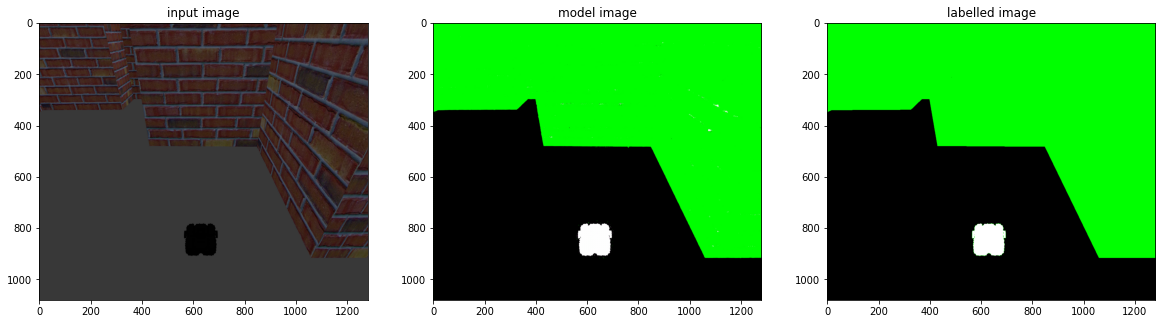

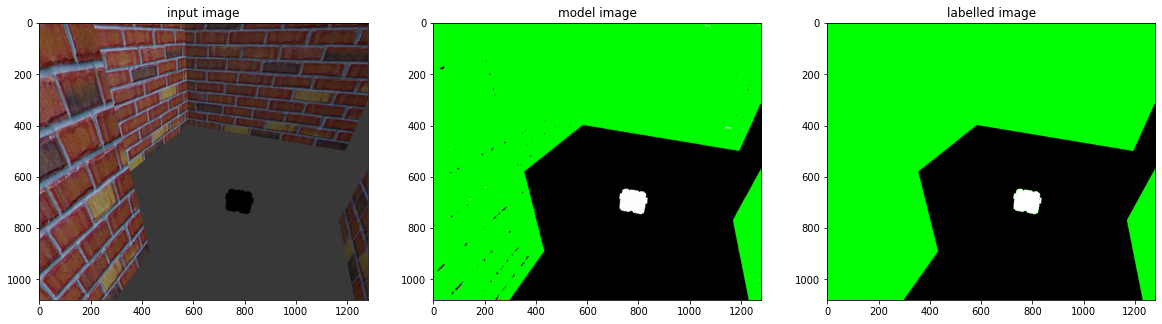

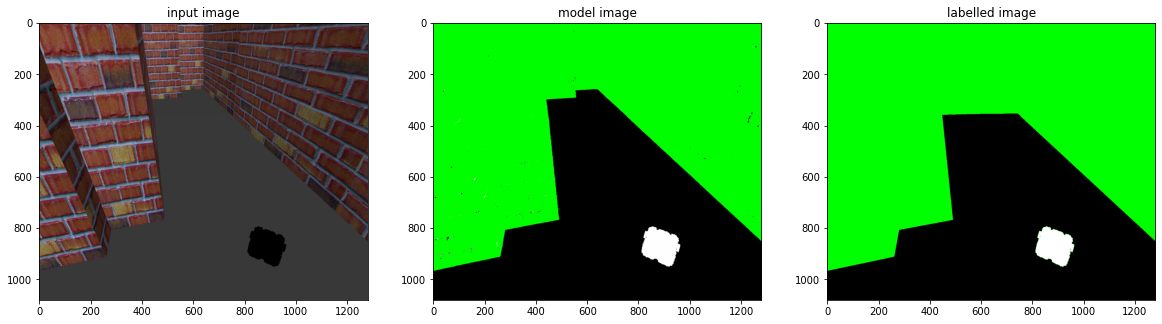

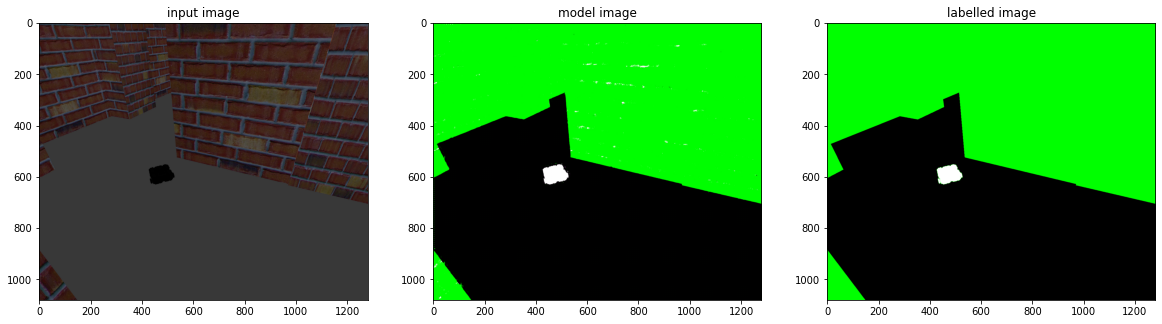

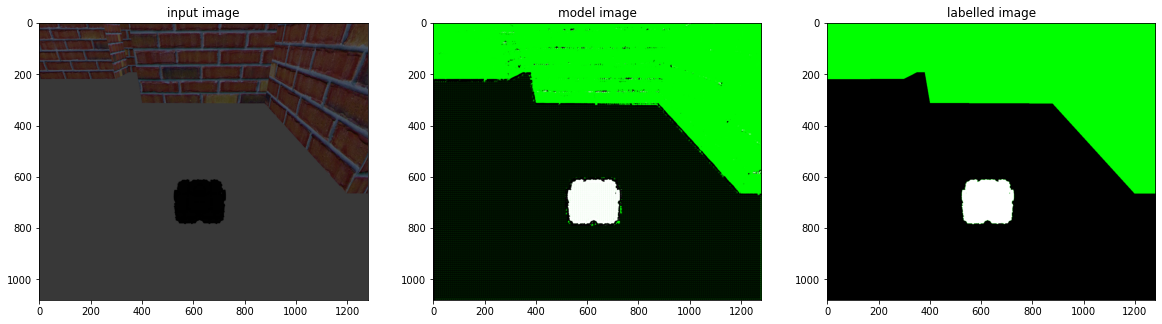

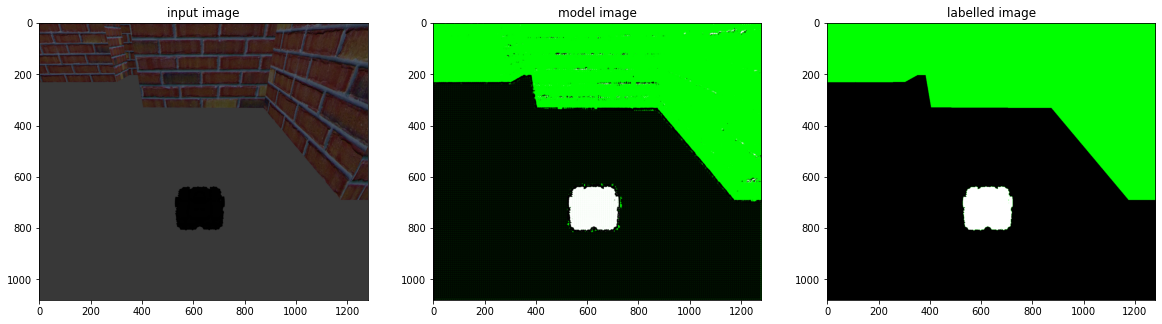

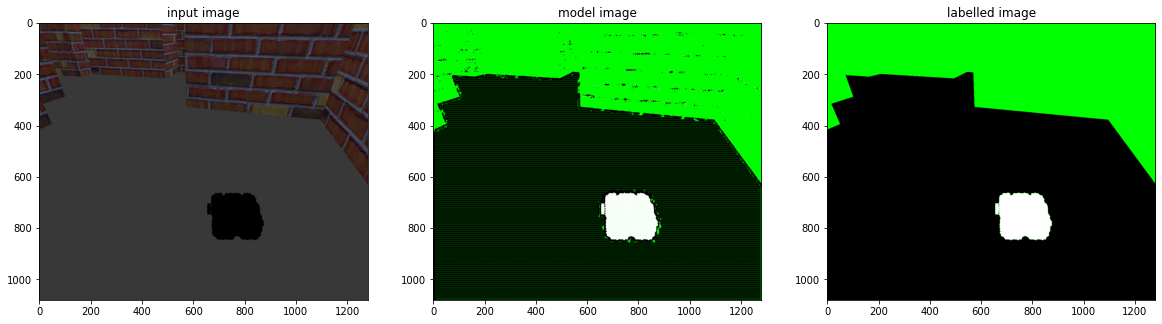

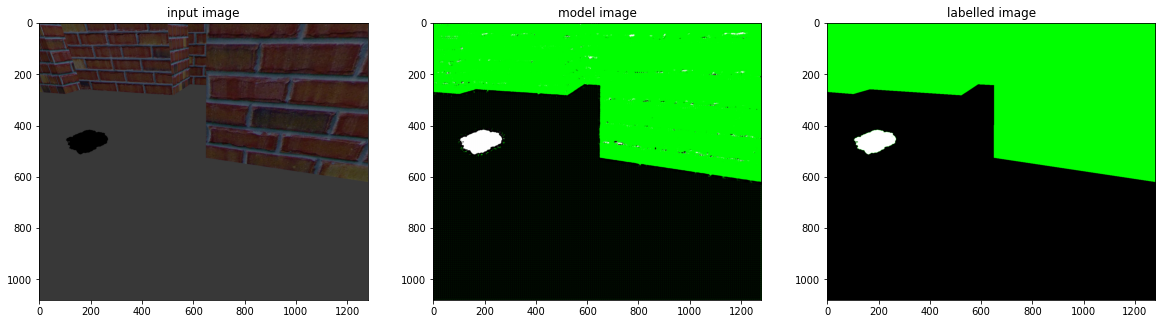

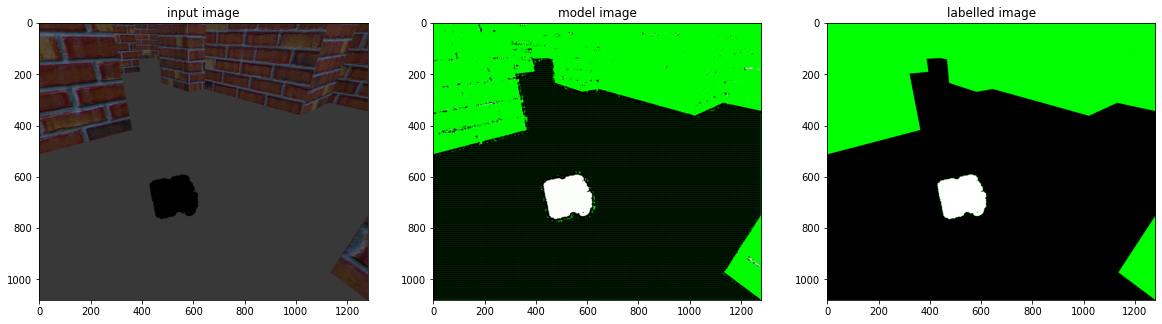

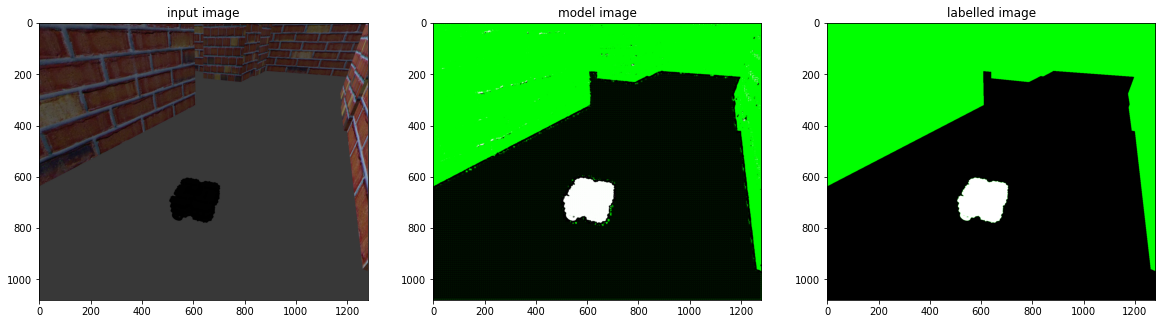

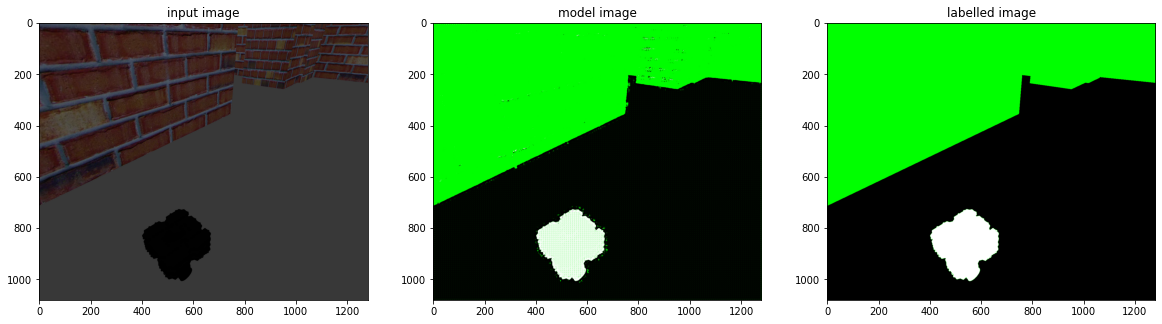

In [39]:
import os
print(os.getcwd())
path = "./random test"
required_output = "./random_test_correct_output_images"
image = DataDB(path,required_output)
loss_history = []
for i in range(len(image)):
        reocnstructed_image = encoder_decoder(image[i][0][None,...]).to(device)
        v = loss_function(reocnstructed_image[0], image[i][1]).detach().numpy()
        print(v)
        reocnstructed_image = (transforms.ToPILImage()(reocnstructed_image[0])).convert("RGB") 
        input_image = (transforms.ToPILImage()(image[i][0])).convert("RGB")
        best_image = (transforms.ToPILImage()(image[i][1])).convert("RGB")
        loss_history.append(v)
        fig = plt.figure()
        fig.set_size_inches(20, 20)

        ax_2 = fig.add_subplot(1, 3, 1)
        ax_2.set_title("input image")
        plt.imshow(input_image)

        ax_3 = fig.add_subplot(1, 3, 2)
        ax_3.set_title("model image")
        plt.imshow(reocnstructed_image)

        ax_1 = fig.add_subplot(1, 3, 3)
        ax_1.set_title("labelled image")
        plt.imshow(best_image)
